In [26]:
import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy

In [27]:
# Fundamental building block of any sound: a single sine wave with a frequency, amplitude, and length (n_samples/sampling_rate)
def generate_sine_wave(freq, amp=1, n_samples=16_000, sampling_rate=16_000):
  x = np.arange(n_samples)
  y = amp*np.sin(2 * np.pi * freq * x / sampling_rate)
  return x, y

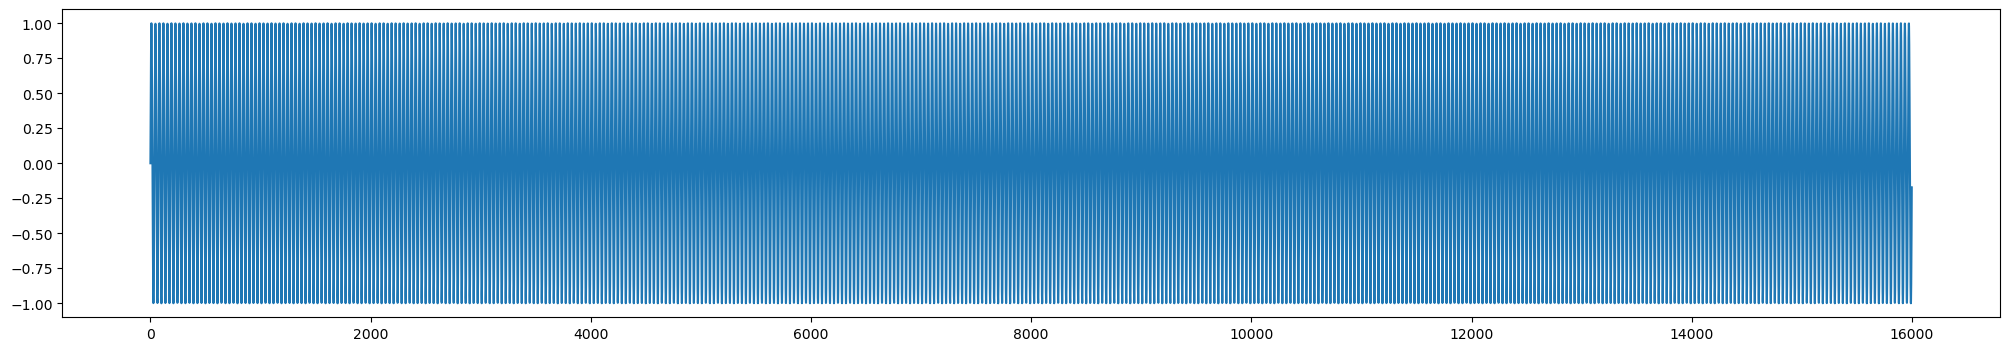

In [28]:
# Sample generation of basic sound wave
sine_440hz_x, sine_440hz_y = generate_sine_wave(440)

plt.figure(figsize=(25,4))
plt.plot(sine_440hz_x, sine_440hz_y)

ipd.Audio(sine_440hz_y, rate=16_000)

In [29]:
# Function to help compose waves together, creating a more blended, complex sound.
def overlay_waves(y1, y2, offset=0, wrap=False):
    composite_y = list(y1)
    n_samples = len(y2)
    for i in range(n_samples):
        if wrap:
            composite_y[i] += y2[(i + offset) % n_samples]
        else:
            if i + offset >= len(y1):
                composite_y.append(y2[i])
            else:
                composite_y[i + offset] += y2[i]

    return composite_y

In [50]:
# Extension of basic building block for more natural pitches by incorporating overtones
# A sound is defined by the strength and frequency of its overtones, and many possible parameters are included here
# n_overtones: the number of overtones to calculate and compose together
# overtone_noise: the deviation from the real overtone series to incorporate (as a normal distribution)
# offset: the offset between overtone waves as they are composed together
# strengths: the pattern of amplitude of overtones, can be harmonic, random, or constant
# - harmonic: strength is given by 1/overtone number
# - random: strength is given by a uniform distribution bounded by the original amplitude
# - constant: strength of all overtones is equal to the original amplitude
# * Note: Defining these specifically can give a specific instrument's sound
# open: whether the resonant body modeled is open or closed. 
# - open resonant bodies activate every overtone
# - closed resonant bodies only activate odd overtones
def generate_pitch_with_overtones(n_samples, sampling_rate, amp, freq, 
                                  n_overtones=10, overtone_noise=0, offset=0, strengths="harmonic", 
                                  open=True):
    _, composite_pitch = generate_sine_wave(freq, amp, n_samples, sampling_rate)
    for i in range(2, n_overtones + 1):
        if not open and i % 2 == 0:
            continue
        overtone_frequency = freq * i + np.random.normal(0, overtone_noise)
        if strengths == "harmonic":
            overtone_strength = amp / i
        elif strengths == "random":
            overtone_strength = np.random.uniform(0, amp)
        elif strengths == "constant":
            overtone_strength = amp
        else:
            overtone_strength = 0
        _, overtone_y = generate_sine_wave(overtone_frequency, overtone_strength, n_samples, sampling_rate)
        composite_pitch = overlay_waves(composite_pitch, overtone_y, offset=offset * i, wrap=True)
    return np.arange(n_samples), composite_pitch

Below are a series of filters which can be applied to a sound wave. Filters are essentially functions which take in a sound wave to generate a modified version of it. Each of the functions ending in "filter" below returns a filter, not a filtered sound wave. This returned filter can then be passed to apply_filters() along with any sound wave to obtain the modified version.
Why is it set up like this? That way, the user can set parameters for a filter just one time and use it on multiple sound waves. There can also be more flexible scheduling of filter application.

In [111]:
def apply_filters(sound, filters):
    # If a single filter is passed in, promote it to a list containing the single filter in order for the processing to succeed
    if type(filters) != list:
        filters = [filters]

    # Sequentially apply filters to the given sound
    result = sound
    for filter in filters:
        result = filter(result)
    return result

In [32]:
# Deprecated; use linear_decay_filter()
def linear_decay(x, y):
    n_samples = len(x)
    new_y = []
    for i in range(n_samples):
        new_y.append(y[i] * (n_samples - i) / n_samples)
    return x, new_y

In [33]:
# Deprecated; use exponential_decay_filter()
def exponential_decay(x, y, rate=1e-2):
    n_samples = len(x)
    new_y = [y[0]]
    for i in range(1, n_samples):
        new_y.append(y[i] * (rate) ** (i / n_samples))
    return x, new_y

In [34]:
# Linear Decay Filter: Applies decay to the amplitude of the sound wave linearly
def linear_decay_filter():
    def filter(x):
        n_samples = len(x)
        return [x[i] * (n_samples - i) / n_samples for i in range(n_samples)]
    return filter

In [35]:
# Exponential Decay Filter: Applies decay to the amplitude of the sound wave exponentially based on the given rate
def exponential_decay_filter(rate=1e-2):
    def filter(x):
        n_samples = len(x)
        return [x[i] * (rate ** (i / n_samples)) for i in range(n_samples)]
    return filter

In [36]:
# Helper function for the Noise Filter to give a function determining the amount of noise to add
def get_noise_spline(n_nodes, noise=0.1, dist="uniform"):
    if dist == "normal":
        noise_factors = np.random.normal(1, noise, (n_nodes))
    elif dist == "uniform":
        noise_factors = np.random.uniform(-1 * noise + 1, noise + 1, (n_nodes))
    else:
        noise_factors = np.random.uniform(-1 * noise + 1, noise + 1, (n_nodes))
    noise_spline = scipy.interpolate.CubicSpline(np.arange(n_nodes), noise_factors)
    return noise_spline

In [37]:
# Noise Filter: Applies noise to the sound based on two parameters: the intensity and the smoothness of the noise
def noise_filter(noise=0.1, smooth=1, dist="uniform"):
    def filter(x):
        n_samples = len(x)
        n_nodes = n_samples // smooth
        noise_spline = get_noise_spline(n_nodes, noise, dist)
        return [x[i] * noise_spline(n_nodes * i / n_samples) for i in range(n_samples)]
    return filter

In [38]:
# Deprecated; use rounding_filter()
def soften_attack(y, softness=0.1):
    softened_y = y
    n_samples = len(y)
    for i in range(0, n_samples):
        softened_y[i] *= math.atan(i/(n_samples * softness) / (math.pi/2))
    return softened_y

In [39]:
# Deprecated; use rounding_filter()
def soften_release(y, softness=0.1):
    softened_y = y
    n_samples = len(y)
    for i in range(0, n_samples):
        softened_y[i] *= math.atan((n_samples - i - 1)/(n_samples * softness) / (math.pi/2))
    return softened_y

In [40]:
# Rounding Filter: Applies a rounding function (atan) to the beginning and/or end of a sound to reduce the sharpness of the edges
def rounding_filter(left, right, roundness=0.1):
    left_filter = lambda x : [x[i] * 1 for i in range(len(x))]
    right_filter = lambda x : [x[i] * 1 for i in range(len(x))]
    if left:
        left_filter = lambda x : [x[i] * math.atan(i/(len(x) * roundness) / (math.pi/2)) for i in range(len(x))]
    if right:
        right_filter = lambda x : [x[i] * math.atan((len(x) - i - 1)/(len(x) * roundness) / (math.pi/2)) for i in range(len(x))]
    filter = lambda x : right_filter(left_filter(x)) 
    return filter


In [42]:
# Deprecated; use contrast_filter()
def contrast_enhance(y, factor=2):
    enhanced_y = y
    max_amp = max(y)
    n_samples = len(y)
    for i in range(n_samples):
        enhanced_y[i] *= abs(enhanced_y[i]) / max_amp
    return enhanced_y

In [92]:
# Contrast Filter: Either sharpens or reduces contrast based on the given parameter by taking exponents,
#                  normalizes to maximum amplitude of sound
def contrast_filter(factor=2):
    def filter(x):
        n_samples = len(x)
        max_amp = max(x)
        print(max_amp)
        normalization_factor = max_amp ** (factor - 1)
        return [x[i] * abs(x[i]) ** (factor - 1) / normalization_factor for i in range(n_samples)]
    return filter

Below are sample generations of sound waves and applications of various filters, combined in a way that starts to resemble instrumental sounds.

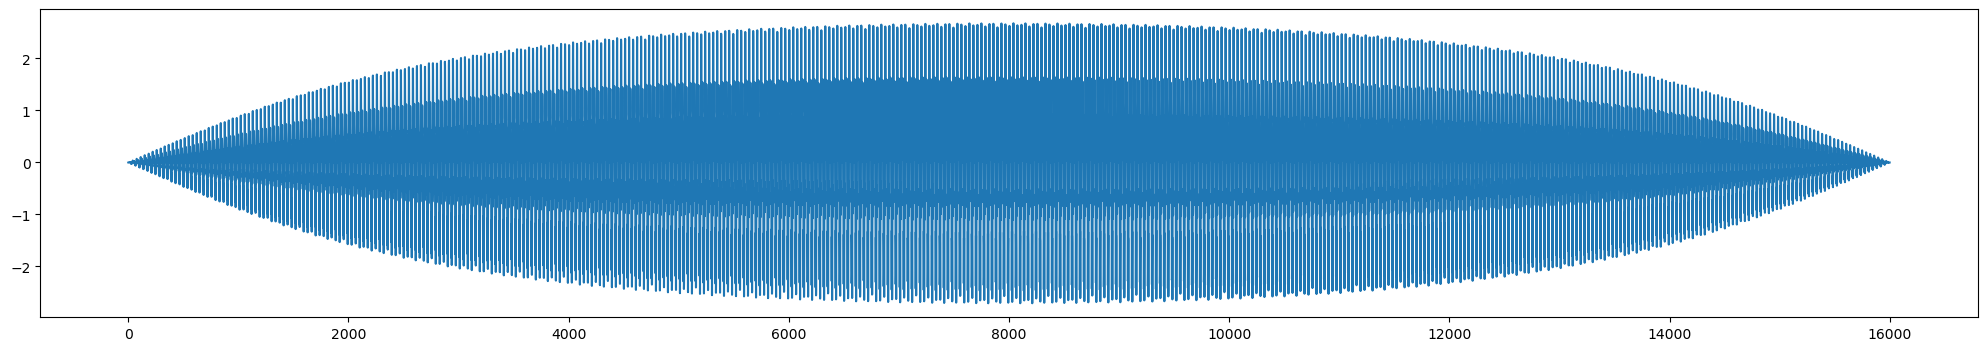

In [113]:
# Sample generation of typical pitch with overtones, plus a rounding filter
a4_x_overtones, a4_y_overtones = generate_pitch_with_overtones(16000, 16000, 1, 440, 10, offset=20)
n_samples = len(a4_x_overtones)
rounding_f = rounding_filter(left=True, right=True, roundness=0.1)
a4_y_overtones = apply_filters(a4_y_overtones, rounding_f)
ipd.Audio(a4_y_overtones, rate=16_000)

plt.figure(figsize=(25,4))
plt.plot(a4_x_overtones, a4_y_overtones)

ipd.Audio(a4_y_overtones, rate=16_000)

1.6503902958771006


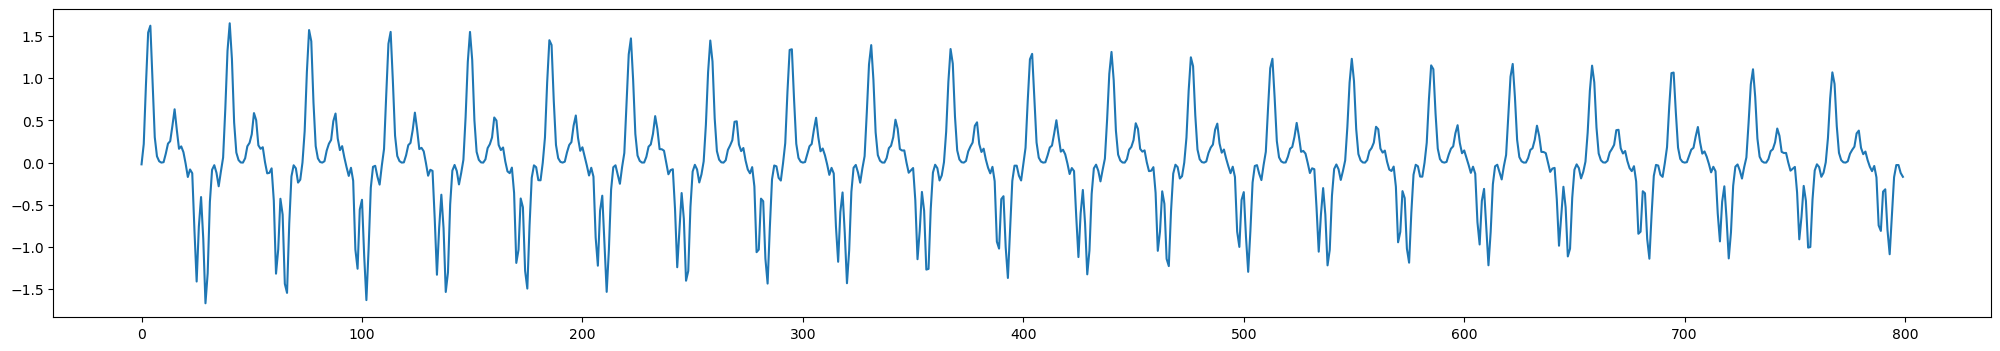

In [112]:
# Testing exponential decay, noise, and contrast filters simultaneously
a4_x_overtones, a4_y_overtones = generate_pitch_with_overtones(16000, 16000, 1, 440, 10, offset=20)
n_samples = len(a4_x_overtones)

# a4_x_overtones, a4_y_overtones = exponential_decay(a4_x_overtones, a4_y_overtones, rate=1e-2)
exp_decay_f = exponential_decay_filter(rate=1e-2)
# a4_y_overtones = apply_filters(a4_y_overtones, exp_decay_f)
noise_f = noise_filter(noise=0.5, smooth=1)
contrast_f = contrast_filter(factor=2)

a4_y_overtones = apply_filters(a4_y_overtones, [exp_decay_f, contrast_f])

ipd.Audio(a4_y_overtones, rate=16_000)

plt.figure(figsize=(25,4))
plt.plot(a4_x_overtones[:800], a4_y_overtones[:800])

ipd.Audio(a4_y_overtones, rate=16_000)

In [45]:
# Obtain the Fourier transform of a sound wave. Calls the numpy implementation by default.
def fourier_transform(y, numpy=True):
    if numpy:
        return np.fft.fft(y)
    else:
        return y

In [46]:
# Obtain the inverse Fourier transform of a transformed sound wave. Calls the numpy implementation by default.
def inverse_fourier_transform(y, numpy=True):
    if numpy:
        return np.fft.ifft(y)
    else:
        return y

c:\Users\andre\miniconda3\envs\tf\lib\site-packages\matplotlib\cbook\__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


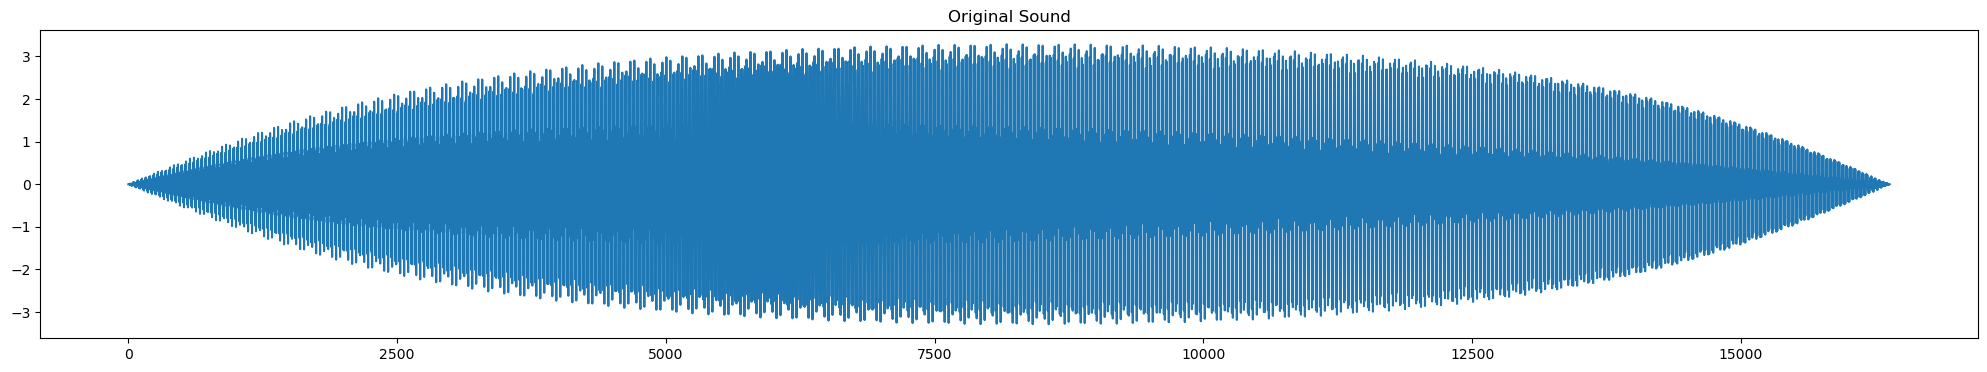

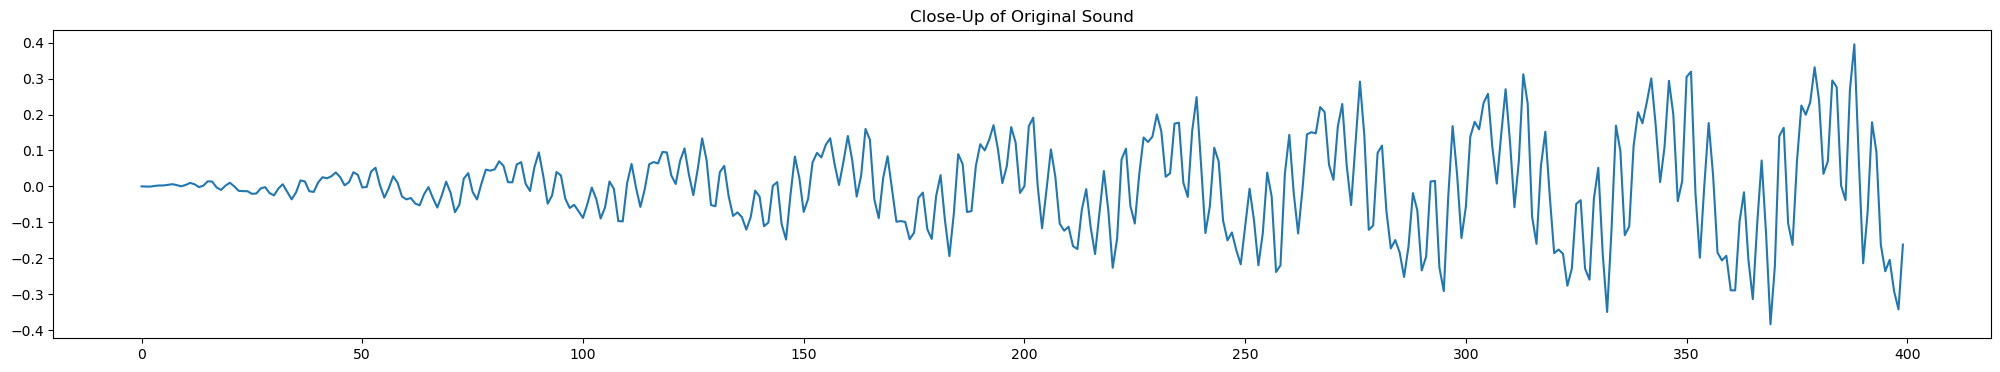

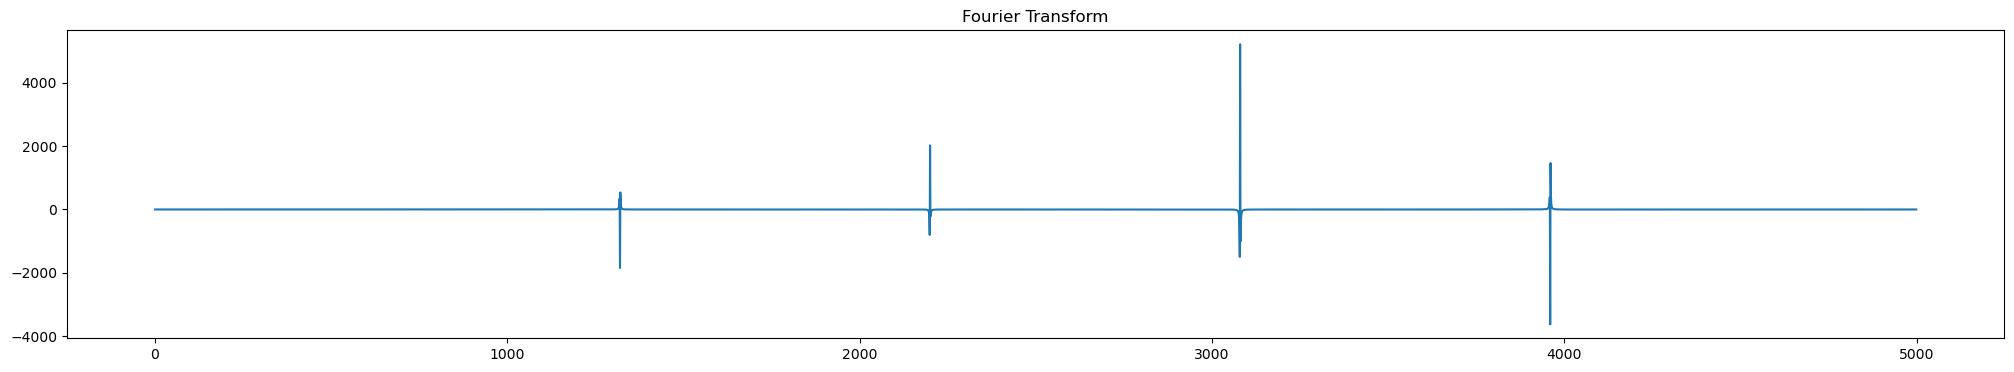

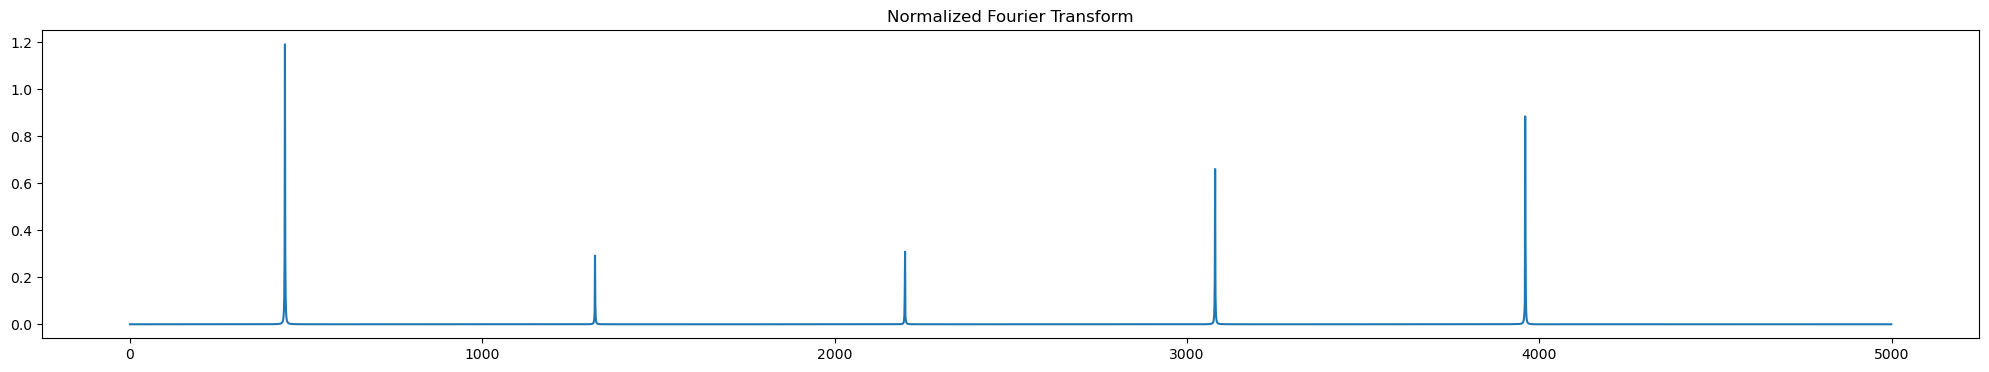

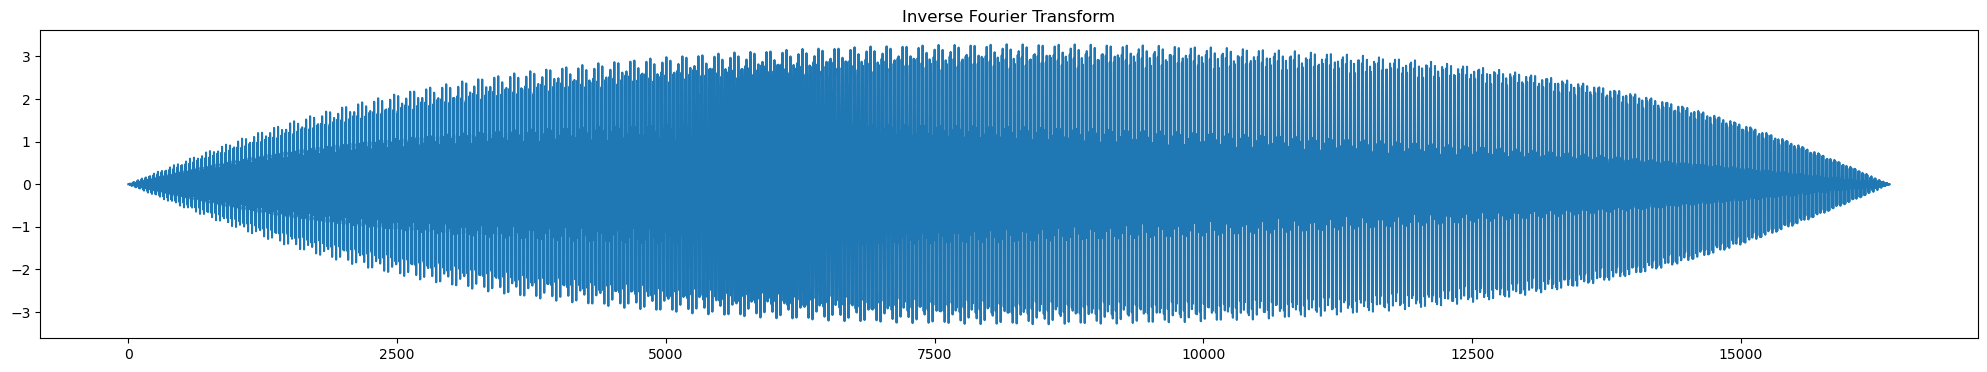

In [114]:
# All about Fourier Transform!
SAMPLING_RATE = 16384
N_SAMPLES = 16384
PITCH_FREQUENCY = 440

# np.random.seed(1337)

_, single_a4 = generate_pitch_with_overtones(N_SAMPLES, SAMPLING_RATE, amp=1, freq=440, 
                                             n_overtones=10, offset=20, strengths="random", overtone_noise=0.1,
                                             open=False)
rounding_f = rounding_filter(left=True, right=True, roundness=0.1)
single_a4 = apply_filters(single_a4, rounding_f)

fourier_a4 = fourier_transform(single_a4)
inverse_fourier = inverse_fourier_transform(fourier_a4)
normalized_fourier_a4 = np.abs(fourier_a4) / (N_SAMPLES / 2)

plt.figure(figsize=(25,4))
plt.plot(np.arange(len(single_a4)), single_a4)
plt.title("Original Sound")

plt.figure(figsize=(25,4))
plt.plot(np.arange(len(single_a4))[:400], single_a4[:400])
plt.title("Close-Up of Original Sound")

plt.figure(figsize=(25,4))
plt.plot(np.arange(len(fourier_a4) // 2)[:5000], fourier_a4[:5000])
plt.title("Fourier Transform")

plt.figure(figsize=(25,4))
plt.plot(np.arange(len(normalized_fourier_a4) // 2)[:5000], normalized_fourier_a4[:5000])
plt.title("Normalized Fourier Transform")

plt.figure(figsize=(25,4))
plt.plot(np.arange(len(inverse_fourier)), inverse_fourier)
plt.title("Inverse Fourier Transform")

ipd.Audio(single_a4, rate=16_000)

32104


c:\Users\andre\miniconda3\envs\tf\lib\site-packages\matplotlib\cbook\__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


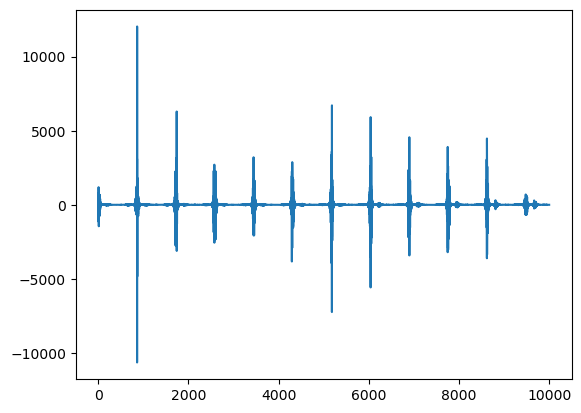

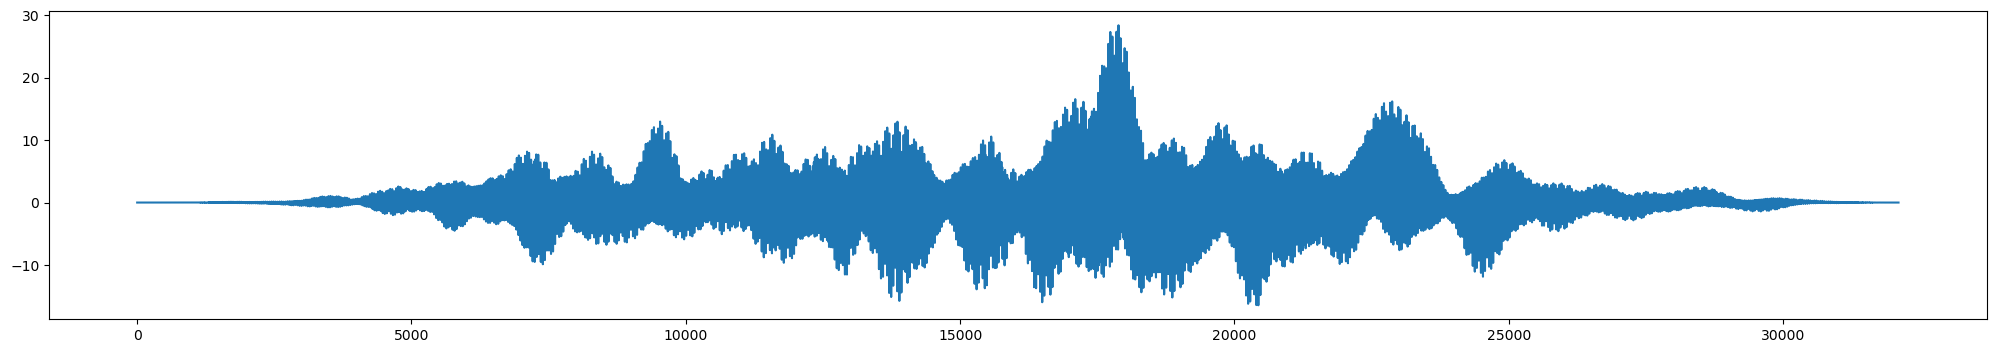

In [47]:
# Testing what a series of consecutive vibrations (sound waves) produces given a controlled amount of variance
SAMPLING_RATE = 16384
N_SAMPLES = 16384
PITCH_FREQUENCY = 440
strength = []
for i in range(N_SAMPLES):
    strength.append(math.sin((i / N_SAMPLES) * math.pi))
_, composite_a4_y = generate_pitch_with_overtones(N_SAMPLES, SAMPLING_RATE, 0, PITCH_FREQUENCY, n_overtones=10, offset=20)
pitch_speed = 25
for i in range(1, pitch_speed):
    # pitch_variance = np.random.uniform(-2, 2)
    pitch_variance = np.random.normal(0, 0.2)
    # _, single_a4 = generate_pitch_with_overtones(N_SAMPLES, SAMPLING_RATE, strength[i * int(SAMPLING_RATE/pitch_speed)], 440 + pitch_variance, 10)
    _, single_a4 = generate_pitch_with_overtones(N_SAMPLES, SAMPLING_RATE, amp=1, freq=440 + pitch_variance, strengths="random", n_overtones=10, overtone_noise=5, offset=20)
    single_a4 = soften_attack(single_a4, 0.1)
    single_a4 = soften_release(single_a4, 0.1)
    composite_a4_y = overlay_waves(composite_a4_y, single_a4, offset=i * int(SAMPLING_RATE/pitch_speed), wrap=False)

composite_a4_y = contrast_enhance(composite_a4_y)

composite_a4_x = np.arange(len(composite_a4_y))
print(len(composite_a4_x))

fourier_composite = fourier_transform(composite_a4_y)
plt.plot(np.arange(len(fourier_composite))[:10000], fourier_composite[:10000])

# composite_a4_x, composite_a4_y = exponential_decay(composite_a4_x, composite_a4_y, rate = 1e-1)

plt.figure(figsize=(25,4))
plt.plot(composite_a4_x, composite_a4_y)

ipd.Audio(composite_a4_y, rate=16_000)